In [1]:
import pandas
import matplotlib
import seaborn
import collections
import itertools

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_data, create_snapshot, load_graph, 
                     evolution_linlog_regressions, RE_SEMVER, compare_distributions, 
                     savefig, x_index)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

In [2]:
FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (10, 4)
FIG_DATE_RANGE = (DATE_RANGE[0], DATE_RANGE[-1])  #(pandas.to_datetime('2007-01-01'), DATE_RANGE[-1])
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}

In [3]:
df_data = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=', ')
    packages, dependencies = load_data(ecosystem)
    df_data[ecosystem] = {
        'packages': packages, 
        'dependencies': dependencies,
    }

cargo, cpan, cran, npm, nuget, packagist, rubygems, 

## Characteristics

In [4]:
df = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    # Number of packages, versions and dependencies
    df.loc[ecosystem, 'packages'] = len(data['packages'].groupby('package'))
    df.loc[ecosystem, 'releases'] = len(data['packages'])
    df.loc[ecosystem, 'dependencies'] = len(data['dependencies'])
    
    # Oldest package
    df.loc[ecosystem, 'from_date'] = data['packages']['time'].min()
    df.loc[ecosystem, 'to_date'] = data['packages']['time'].max()
    
    # Latest snapshot
    sn_packages, sn_dependencies = create_snapshot(data['packages'], data['dependencies'], df.loc[ecosystem, 'to_date'])
    df.loc[ecosystem, 'sn_dependencies'] = len(sn_dependencies)
    
df.T

,cargo,cpan,cran,npm,nuget,packagist,rubygems
packages,8726,34105,9568,462155,84308,97149,132118
releases,48482,258987,57530,3.03762e+06,935651,668905,795224
dependencies,150251,1.07812e+06,128113,1.36945e+07,1.66539e+06,1.8633e+06,1.89357e+06
from_date,2014-11-11 00:22:07,1995-08-19 22:00:00,1997-10-08 19:56:17,2010-11-09 23:36:08,2011-01-07 07:49:38,1994-08-23 00:00:00,1999-12-31 13:30:00
to_date,2017-04-05 11:51:32,2017-04-05 11:19:02,2016-04-26 20:52:26,2017-04-05 00:38:39,2017-04-05 10:17:32,2017-04-05 08:43:17,2017-04-04 17:26:30
sn_dependencies,21840,105429,22191,1.25575e+06,129678,176230,190424


In [5]:
df.sum()

packages             828129.0
releases            5802397.0
dependencies       20473210.0
sn_dependencies     1901541.0
dtype: float64

## Packages, releases and dependencies over time

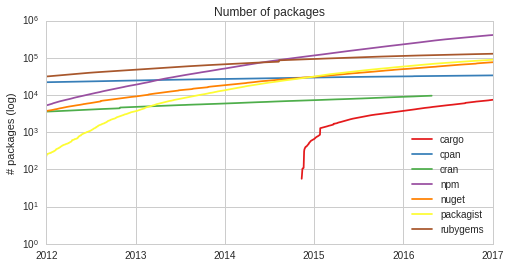

In [6]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby('package')
        [['time']]
        .min()
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of packages',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_number_of_packages')

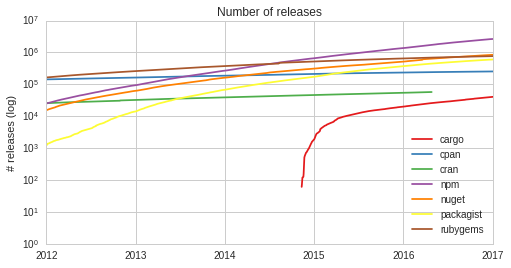

In [7]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='Number of releases',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_number_of_releases')

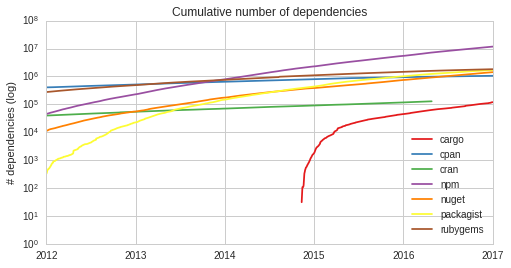

In [8]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .merge(data['dependencies'], how='right', on=['package', 'version'])
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])

ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Cumulative number of dependencies',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_cumulative_number_of_dependencies')

## New packages and releases  by month

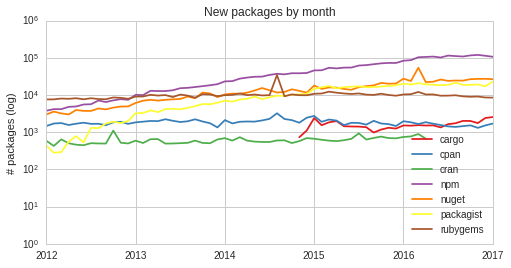

In [9]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby(['package', 'version'])
        [['time']]
        .min()
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='New packages by month',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_new_packages_by_month')

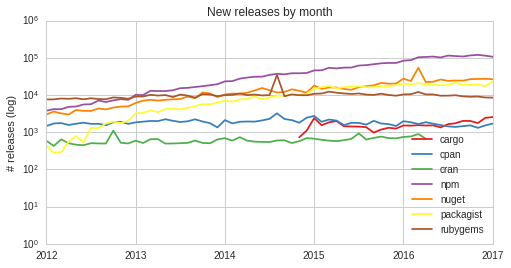

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='New releases by month',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_new_releases_by_month')

## Delay before first update

In [13]:
# Time of first and next release
for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .sort_values(['package', 'time'])
        .set_index(['package', 'version'])
        .assign(next_release=lambda d: d['time'].shift(-1))
    )
    index_of_last_releases = (
        df
        .groupby(level='package', sort=False)
        .tail(1)
        .index
    )
    df.loc[index_of_last_releases, 'next_release'] = pandas.NaT
    df = df.reset_index()
    
    df_data[ecosystem]['packages'] = (
        df
        .groupby('package')
         [['time']]
         .min()
         .assign(first_release=lambda d: d['time'])
         [['first_release']]
         .reset_index()
         .merge(df, how='left', on='package')
    )

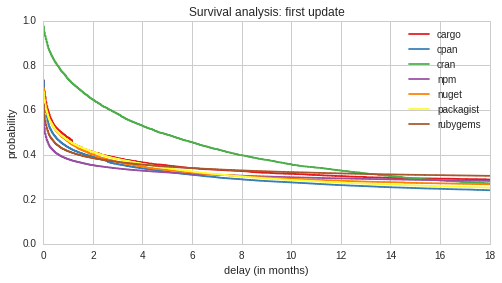

In [12]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():    
    kmp_df = (
        data['packages']
        [data['packages']['time'] == data['packages']['first_release']]
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['first_release'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: first update',
    xlim=(0, 18),
    ylim=(0, 1)
)    


savefig(figure, 'act_survival_first_update')

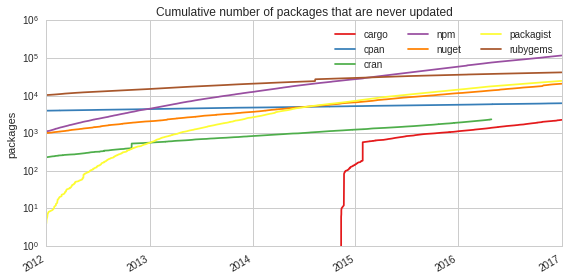

In [13]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame()

for ecosystem, data in df_data.items():    
    df = (
        data['packages']
        .query('time == first_release and next_release != next_release')
        .assign(**{ecosystem: 1})
        .set_index('time')
        [[ecosystem]]
        .sort_index()
        .cumsum()
    )
    df.plot(ax=ax, color=COLORS[ecosystem])
    data_temp = data_temp.join(evolution_linlog_regressions(df), how='outer')
    
ax.set(
    xlabel='',
    ylabel='packages',
    title='Cumulative number of packages that are never updated',
    yscale='log',
    xlim=(DATE_RANGE[0], DATE_RANGE[-1]),
)

ax.legend(ncol=len(ECOSYSTEMS) // 2)

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_cum_number_never_updated')

In [14]:
data_temp

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.968224,0.981608,0.678216,0.855001,0.853353,0.931789,0.947932
lin-log,0.755357,0.856396,0.973404,0.972107,0.951855,0.915640,0.908940
log-lin,0.762404,0.561385,0.258632,0.598017,0.449055,0.494523,0.833197
log-log,0.953596,0.851252,0.583605,0.963937,0.881997,0.541792,0.953768


## Delay between successive releases

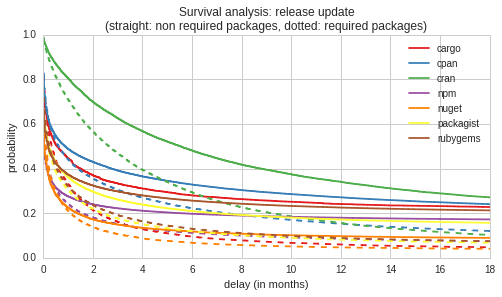

In [15]:
import lifelines
from lifelines.statistics import logrank_test

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for ecosystem, data in df_data.items():
    kmp_df = (
        data['packages']
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
        .assign(required=lambda d: d['package'].isin(data['dependencies']['dependency']))
    )
    
    required = kmp_df['required'] == True
    
    kmp.fit(kmp_df[~required]['duration'], kmp_df[~required]['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'])
    kmp.plot(ax=ax, color=COLORS[ecosystem], style='--', legend=None, ci_show=False)
    
    tests[ecosystem] = logrank_test(
        kmp_df[~required]['duration'], kmp_df[required]['duration'],
        kmp_df[~required]['observed'], kmp_df[required]['observed'],
        alpha=0.99
    )
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: release update\n(straight: non required packages, dotted: required packages)',
    xlim=(0, 18),
    ylim=(0, 1)
)    


savefig(figure, 'act_survival_update_release')

In [16]:
for ecosystem, test in tests.items():
    print('{}: {}, significant: {}'.format(ecosystem, test.test_result, test.is_significant))

cargo: Reject Null, significant: True
cpan: Reject Null, significant: True
cran: Reject Null, significant: True
npm: Reject Null, significant: True
nuget: Reject Null, significant: True
packagist: Reject Null, significant: True
rubygems: Reject Null, significant: True


## Updates by package

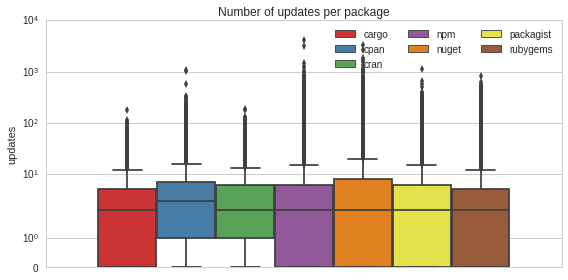

In [4]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame(columns=['ecosystem', 'updates'])

for ecosystem, data in df_data.items():    
    df = (
        data['packages']
        .assign(updates=1)
        .groupby('package')
        [['updates']]
        .count()
        .assign(ecosystem=ecosystem)
        .assign(updates=lambda d: d['updates'] - 1)  # Initial update
    )
    data_temp = pandas.concat([data_temp, df], axis=0)

seaborn.boxplot(
    x='x',
    y='updates',
    hue='ecosystem',
    data=data_temp.reset_index().assign(x=1),    
    palette=COLORS,
    ax=ax,
)

ax.set(
    title='Number of updates per package',
    xlabel='',
    yscale='symlog',
)

ax.set_ylim(bottom=0)
ax.set_xticklabels([''])
ax.legend(ncol=len(ECOSYSTEMS) // 2)


matplotlib.pyplot.tight_layout()

savefig(figure, 'act_updates_by_package')

In [20]:
from scipy import stats

for i in range(len(ECOSYSTEMS)):
    for j in range(i + 1, len(ECOSYSTEMS)):
        a = data_temp[data_temp['ecosystem'] == ECOSYSTEMS[i]]['updates'].values
        b = data_temp[data_temp['ecosystem'] == ECOSYSTEMS[j]]['updates'].values
        
        d, p = stats.ks_2samp(a, b)
        print('{} vs {}: {} ({})'.format(ECOSYSTEMS[i], ECOSYSTEMS[j], d, p))

cargo vs cpan: 0.14093456849814934 (1.1967373944003994e-120)
cargo vs cran: 0.08461011933735876 (6.613583088206744e-29)
cargo vs npm: 0.03045302101980152 (2.4224668458677374e-07)
cargo vs nuget: 0.080463129684896 (5.145192492096927e-45)
cargo vs packagist: 0.05138478069349167 (7.731215901170547e-19)
cargo vs rubygems: 0.019871091767447002 (0.0030630355483870545)
cpan vs cran: 0.07129141192431987 (1.6731285684796892e-33)
cpan vs npm: 0.11124342012852212 (0.0)
cpan vs nuget: 0.10546422042947684 (2.218555580888424e-235)
cpan vs packagist: 0.0899744176792629 (3.4050487564324884e-178)
cpan vs rubygems: 0.12905043242798336 (0.0)
cran vs npm: 0.054918970967731545 (4.810912785722287e-25)
cran vs nuget: 0.0749963097167371 (1.6309872322090935e-42)
cran vs packagist: 0.03322533864386709 (8.463461837776195e-09)
cran vs rubygems: 0.06473902756991176 (5.478153785447351e-33)
npm vs nuget: 0.06522749457565191 (3.7062849140915318e-264)
npm vs packagist: 0.021693632323864454 (2.879442651729357e-33)
npm 

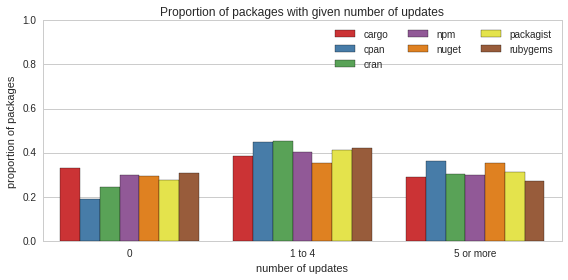

In [19]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = []

bins = [0, 1, 5, pandas.np.inf]
labels = ['0', '1 to 4', '5 or more']

for ecosystem, data in df_data.items():    
    df = (
        data['packages']
        .assign(updates=1)
        .groupby('package')
        [['updates']]
        .count()
        .assign(updates=lambda d: d['updates'] - 1)  # Initial update
        ['updates']
    )
    
    counter = collections.Counter(
            pandas.cut(
                df,
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
    
    nb_packages = len(data['packages'].drop_duplicates(['package']))
    for label in labels: 
        data_temp.append((ecosystem, label, counter[label] / nb_packages))
    

seaborn.barplot(
    data=pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'value', 'p']),
    x='value', 
    y='p', 
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Proportion of packages with given number of updates',
    xlabel='number of updates',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

ax.legend(ncol=len(ECOSYSTEMS) // 2)

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_nb_packages_updates_by_package')

## Update index

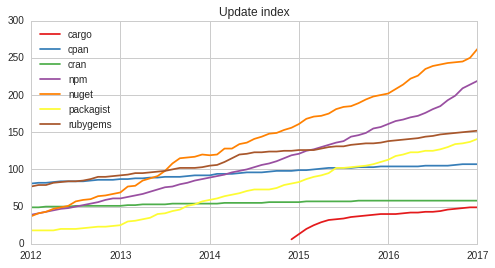

In [10]:
figure, ax = matplotlib.pyplot.subplots(1)
figure.set_size_inches(FIG_SIZE)

data_temp = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    df_temp = data['packages'][['package', 'time']].copy()
    
    for date in DATE_RANGE[::-1]: 
        df_temp = df_temp[df_temp['time'] <= date]
        
        if len(df_temp) == 0:
            break
            
        index = x_index(
            df_temp
            .groupby('package')
            .count()
            ['time']
            .values
        )
        data_temp.loc[date, ecosystem] = index
        
data_temp.plot(ax=ax)

ax.set(
    title='Update index',
    xlabel='',
    ylabel='',
)

savefig(figure, 'act_update_index')

In [11]:
evolution_linlog_regressions(data_temp.astype(float))

,cargo,cpan,cran,npm,nuget,packagist,rubygems
lin-lin,0.814106,0.986779,0.945417,0.977484,0.995816,0.990919,0.987481
lin-log,0.579963,0.981718,0.938746,0.992581,0.952162,0.950855,0.975221
log-lin,0.892481,0.652662,0.70555,0.541691,0.606121,0.560296,0.633085
log-log,0.974611,0.673423,0.71787,0.689689,0.757273,0.680346,0.682833


## Correlation between updates and dependencies

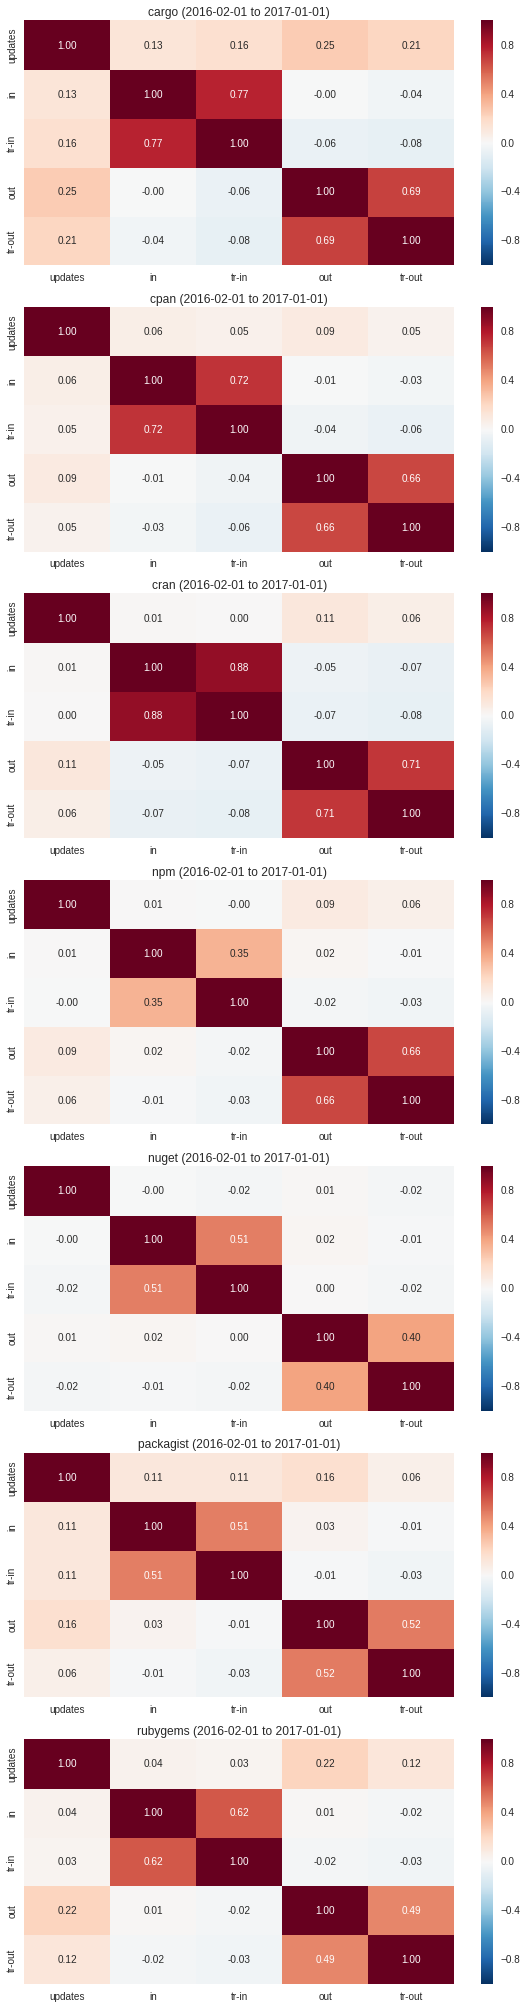

In [18]:
figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1]*len(ECOSYSTEMS)))

INTERVAL = [DATE_RANGE[-12], DATE_RANGE[-1]]

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    graph = load_graph(ecosystem, INTERVAL[0])
    mask = (INTERVAL[0] <= data['packages']['time']) & (data['packages']['time'] < INTERVAL[1])

    updates = (
        data['packages'][mask]
        [['package', 'version']]
        .groupby('package')
        .count()
        .reset_index()
        .rename(columns={'version': 'updates'})
    )

    for metric in ['in', 'tr-in', 'out', 'tr-out']:
        metric_df = pandas.DataFrame.from_records(
            zip(graph.vs['name'], graph.vs[metric]), 
            columns=['package', metric]
        )
        updates = updates.merge(metric_df, on='package')

    updates = updates.set_index('package').fillna(0)
    
    seaborn.heatmap(updates.corr(), annot=True, fmt='2.2f', ax=ax)
    ax.set(
        title='{} ({} to {})'.format(
            ecosystem, 
            INTERVAL[0].strftime('%Y-%m-%d'),
            INTERVAL[1].strftime('%Y-%m-%d')
        ),
    )
    
matplotlib.pyplot.tight_layout()    


savefig(figure, 'act_correlation_update_degree')

## Packages with semver

In [19]:
# Extract semver
for ecosystem, data in df_data.items():
    data['packages'] = (
        pandas.concat([
            data['packages'], 
            data['packages']['version'].str.extract(RE_SEMVER, expand=True)
        ], axis=1, join='inner')
        .assign(semver=lambda d: ~(d[['v_major', 'v_minor', 'v_patch']].isnull().any(axis=1)))
        # Convert to int
        .assign(
            v_major=lambda d: pandas.to_numeric(d['v_major'], errors='ignore'),
            v_minor=lambda d: pandas.to_numeric(d['v_minor'], errors='ignore'),
            v_patch=lambda d: pandas.to_numeric(d['v_patch'], errors='ignore'),
        )
    )

In [20]:
# Tag package "semver_all" if all its releases are semver compliant
for ecosystem, data in df_data.items():
    not_semver = (
        data['packages']
        .query('semver == False')
        ['package']
    )
    data['packages'] = (
        data['packages']
        .assign(semver_all=lambda d: ~d['package'].isin(not_semver))
    )
    
# Tag release "semver_adopted" if current and all next releases are semver compliant
for ecosystem, data in df_data.items():
    data['packages'] = (
        data['packages']
        .query('semver == False')
        .groupby('package')
        [['time']]
        .max()
        .rename(columns={'time': 'last_non_semver'})
        .merge(
            data['packages'], 
            how='right', 
            right_on='package',
            left_index=True
        )
        .assign(semver_adopted=lambda d: d['time'] > d['last_non_semver'])
        .drop(['last_non_semver'], axis=1)
    )

In [21]:
# Detect release type
for ecosystem, data in df_data.items():

    df = (
        data['packages']
        # Keep packages that are semver compliant
        .query('semver_adopted == True')
        .sort_values(['package', 'v_major', 'v_minor', 'v_patch', 'time'])

        # Shift to combine previous/current version
        .pipe(lambda d: 
            d.join(
                d[['package', 'v_major', 'v_minor', 'v_patch', 'time']].shift(1),
                rsuffix='_previous'
            )
        )
        # Shift to combine next version
        .pipe(lambda d: 
            d.join(
                d[['package', 'time']].shift(-1),
                rsuffix='_next'
            )
        )
        .assign(release_type='patch')
        .assign(release_delay=lambda d: d['time'] - d['time_previous'])
        .assign(next_release_delay=lambda d: d['time_next'] - d['time'])
    )

    #df.loc[df['v_patch'] != df['v_patch_previous'], 'release_type'] = 'patch'
    df.loc[df['v_minor'] != df['v_minor_previous'], 'release_type'] = 'minor'
    df.loc[df['v_major'] != df['v_major_previous'], 'release_type'] = 'major'
    df.loc[df['package'] != df['package_previous'], 'release_type'] = 'initial'
    df.loc[df['package'] != df['package_previous'], 'release_delay'] = pandas.NaT
    df.loc[df['package'] != df['package_next'], 'next_release_delay'] = pandas.NaT

    data['semver'] = df.drop(
        ['semver', 'package_previous', 'v_patch_previous', 'v_minor_previous', 
         'v_major_previous', 'time_previous', 'package_next', 'time_next'],
        axis=1
    )

cargo: min is 1.0, last is [ 1.]
cpan: min is 0.0, last is [ 0.08006684]
cran: min is 0.0, last is [ 0.3943662]
npm: min is 1.0, last is [ 1.]
nuget: min is 1.0, last is [ 1.]
packagist: min is 0.021739130434782608, last is [ 0.87229898]
rubygems: min is 0.5714285714285714, last is [ 0.98195374]


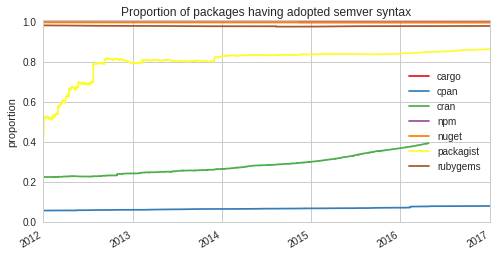

In [22]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .groupby('package')
        [['time']]
        .min()
        .assign(n=1)
        .merge(
            (
                data['semver']
                .groupby('package')
                [['time']]
                .min()
                .assign(n_semver=1)
            ),
            how='outer',
            on='time',
        )
        .fillna(0)
        .set_index('time')
        .sort_index()
        .cumsum()
        .assign(**{ecosystem: lambda d: d['n_semver'] / d['n']})
    )
    print('{}: min is {}, last is {}'.format(ecosystem, df[ecosystem].min(), df.tail(1)[ecosystem].values))
    df[[ecosystem]].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Proportion of packages having adopted semver syntax',
    xlim=FIG_DATE_RANGE,
    ylim=(0, 1.01),
)


savefig(figure, 'act_packages_with_semver')

## Delay to adopt semver

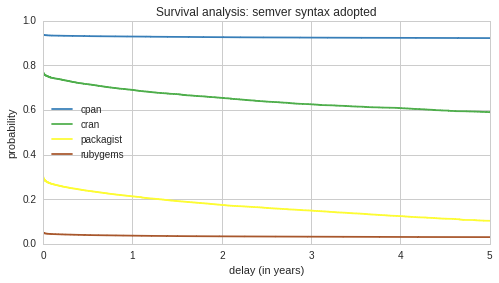

In [23]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():    
    if ecosystem in ['npm', 'cargo', 'nuget']:
        continue
        
    kmp_df = (
        data['packages']
        .groupby('package')
        [['time']]
        .min()
        .rename(columns={'time': 'first_release'})
        .join(
            (
                data['semver']
                .groupby('package')
                [['time']]
                .min()
                .rename(columns={'time': 'first_semver'})
            ),
            how='left', 
        )
        .assign(observed=lambda d: ~d['first_semver'].isnull())
        .fillna(data['packages']['time'].max())
        .assign(duration=lambda d: (d['first_semver'].astype('datetime64[ns, UTC]') - d['first_release'].astype('datetime64[ns, UTC]')).dt.days / 365)
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
ax.set(
    xlabel='delay (in years)',
    ylabel='probability', 
    title='Survival analysis: semver syntax adopted',
    xlim=(0, 5),
    ylim=(0, 1)
)    


savefig(figure, 'act_survival_adopt_semver')

## Type of releases for packages with semver

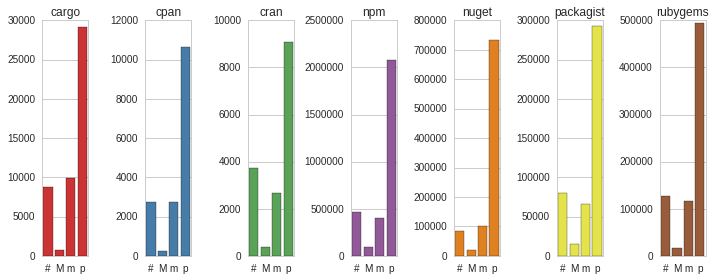

In [24]:
figure, axes = matplotlib.pyplot.subplots(ncols=len(ECOSYSTEMS))
figure.set_size_inches(FIG_SIZE_WIDE)

# figure.suptitle('Type of release for packages following semver')

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    seaborn.countplot(
        x='release_type', 
        data=data['semver'],# .query('release_type != "initial"'),
        order=['initial', 'major', 'minor', 'patch'],
        color=COLORS[ecosystem],
        ax=ax
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='',
        # yscale='log',
    )
    ax.set_xticklabels(['#', 'M', 'm', 'p'])

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_type_of_releases')

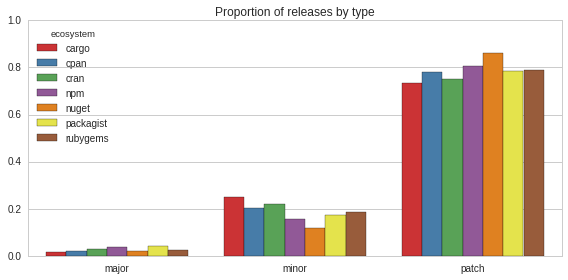

In [25]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = []

for ecosystem, data in df_data.items():
    data = (
        data['semver']
        .query('release_type != "initial"')
        .assign(n=1)
        .groupby('release_type')
        [['n']]
        .count()
        .pipe(lambda d: d / d.sum())
    )
    
    for kind in ['major', 'minor', 'patch']:
        data_temp.append((ecosystem, kind, data.loc[kind, 'n']))


seaborn.barplot(
    x='kind',
    order=['major', 'minor', 'patch'],
    y='p',
    hue='ecosystem',
    palette=COLORS,
    data=pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'kind', 'p']),
    ax=ax
)

ax.set(
    title='Proportion of releases by type',
    xlabel='',
    ylabel='',
    ylim=(0, 1),
)

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_type_of_releases_prop')

## Distribution of release types per package

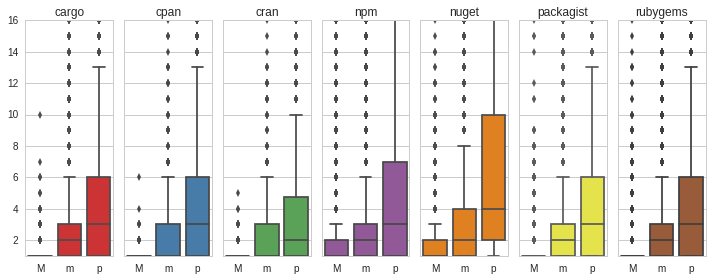

In [26]:
figure, axes = matplotlib.pyplot.subplots(ncols=len(ECOSYSTEMS), sharey=True)
figure.set_size_inches(FIG_SIZE_WIDE)

# figure.suptitle('Type of release for packages following semver')

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    seaborn.boxplot(
        x='release_type', 
        y='version',
        data=data['semver'].groupby(['package', 'release_type']).count().reset_index(),
        order=['major', 'minor', 'patch'],
        color=COLORS[ecosystem],
        ax=ax
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='',
        # yscale='log',
        ylim=(1, 16),
    )
    ax.set_xticklabels(['M', 'm', 'p'])

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_types_distribution')

## Number of patch releases per minor release, minor releases per major release and majors releases per package

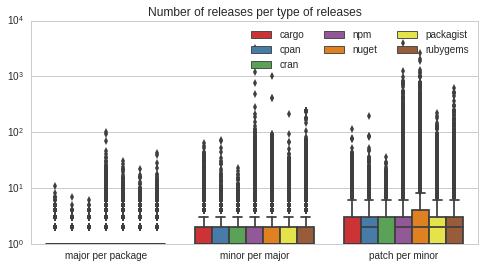

In [27]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = []
for ecosystem, data in df_data.items():
    patches = (
        data['semver']
        [['package', 'v_major', 'v_minor', 'v_patch']]
        .groupby(['package', 'v_major', 'v_minor'])
        .count()
        ['v_patch']
    )

    minors = (
        data['semver']
        [['package', 'v_major', 'v_minor']]
        .drop_duplicates()
        .groupby(['package', 'v_major'])
        .count()
        ['v_minor']
    )
    
    majors = (
        data['semver']
        [['package', 'v_major']]
        .drop_duplicates()
        .groupby('package')
        .count()
        ['v_major']
    )
    
    for label, nbs in [('patch per minor', patches), ('minor per major', minors), ('major per package', majors)]:
        for nb in nbs:
            data_temp.append((ecosystem, label, nb))

data_temp = pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'type', 'n'])   
            
seaborn.boxplot(
    x='type',
    y='n', 
    hue='ecosystem',
    data = data_temp,
    order=['major per package', 'minor per major', 'patch per minor'], 
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Number of releases per type of releases',
    xlabel='', 
    ylabel='',
    yscale='log',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'act_semver_types_distribution_per_types')

In [28]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for a, b in [('major per package', 'minor per major'), ('minor per major', 'patch per minor')]:
        df = data_temp.query('ecosystem == "{}"'.format(ecosystem))
        a_v = df[df['type'] == a]['n'].values
        b_v = df[df['type'] == b]['n'].values
    
        score, p_value, d, label = compare_distributions(a_v, b_v)
        print('{} < {} : {} (p-value: {}), Cliff\'s delta: {} ({})'.format(a, b, score, p_value, d, label))
    print()

cargo
major per package < minor per major : 28533469.5 (p-value: 0.0), Cliff's delta: 0.3051557771621834 (small)
minor per major < patch per minor : 81156197.5 (p-value: 1.135058451051003e-63), Cliff's delta: 0.10927840311817213 (negligible)

cpan
major per package < minor per major : 2909829.0 (p-value: 1.4821274287090221e-143), Cliff's delta: 0.2853020734089484 (small)
minor per major < patch per minor : 6831315.5 (p-value: 2.1139976554402318e-64), Cliff's delta: 0.20133304931362359 (small)

cran
major per package < minor per major : 5755449.5 (p-value: 1.0037044193325388e-150), Cliff's delta: 0.23980215794792464 (small)
minor per major < patch per minor : 10976166.0 (p-value: 1.2180839760085478e-86), Cliff's delta: 0.2017149486906334 (small)

npm
major per package < minor per major : 107758056446.5 (p-value: 0.0), Cliff's delta: 0.16195920109328238 (small)
minor per major < patch per minor : 193939180632.5 (p-value: 0.0), Cliff's delta: 0.27467057679699464 (small)

nuget
major per p

## Highest major component value per package

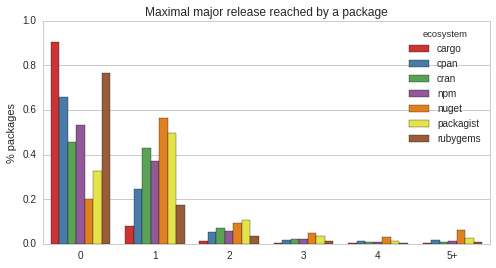

In [29]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5+']

data_temp = []
for ecosystem, data in df_data.items():
    
    df = (data['semver']
          [['package', 'v_major']]
          .drop_duplicates(['package', 'v_major'])
          .sort_values('v_major')
          .drop_duplicates(['package'], keep='last')
          ['v_major']
          .astype(int)
    )
    
    counter = collections.Counter(
            pandas.cut(
                df,
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
    
    nb_packages = len(data['semver'].drop_duplicates(['package']))
    for label in labels: 
        data_temp.append((ecosystem, label, counter[label] / nb_packages))

seaborn.barplot(
    data=pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'value', 'p']),
    x='value', 
    y='p', 
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Maximal major release reached by a package',
    xlabel='',
    ylabel='% packages',
    ylim=(0, 1),
)

savefig(figure, 'act_semver_highest_major')

## Major component for initial release

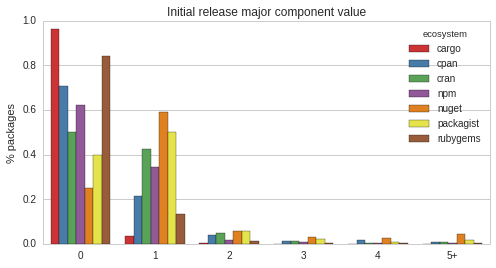

In [30]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5+']

data_temp = []
for ecosystem, data in df_data.items():
    
    df = (data['semver']
          .query('release_type == "initial"')
          [['package', 'v_major']]
          ['v_major']
          .astype(int)
    )
    
    counter = collections.Counter(
            pandas.cut(
                df,
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
    
    nb_packages = len(data['semver'].drop_duplicates(['package']))
    for label in labels: 
        data_temp.append((ecosystem, label, counter[label] / nb_packages))

seaborn.barplot(
    data=pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'value', 'p']),
    x='value', 
    y='p', 
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Initial release major component value',
    xlabel='',
    ylabel='% packages',
    ylim=(0, 1),
)

savefig(figure, 'act_semver_initial_major')

## Number of releases per major component, per package

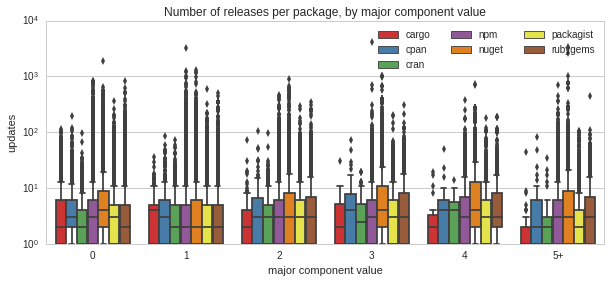

In [31]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE_WIDE)

bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5+']

df = pandas.concat(
    [
        df_data[ecosystem]['semver']
            [['package', 'v_major', 'version']]
            .groupby(['package', 'v_major'])
            .count()
            [['version']]
            .reset_index()
            .assign(v_major=lambda d: pandas.cut(
                  d['v_major'].astype(int),
                  bins=bins,
                  labels=labels,
                  right=False,
                  include_lowest=True)
            )
            .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ]
)

seaborn.boxplot(
    data=df,
    x='v_major',
    y='version',
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Number of releases per package, by major component value',
    xlabel='major component value',
    ylabel='updates',
    yscale='log',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'act_semver_releases_by_major')

## Delay for a release, by release type

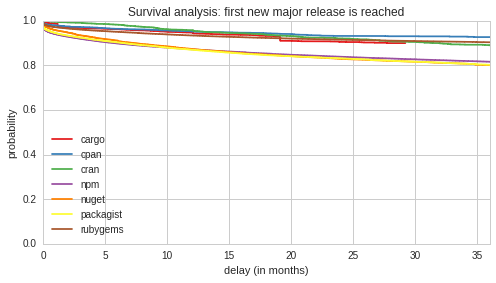

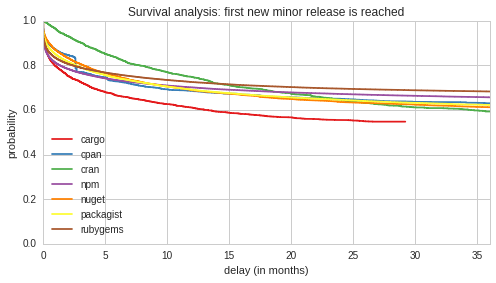

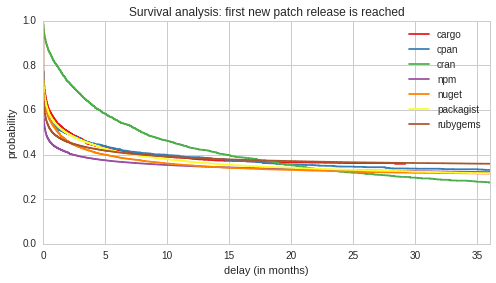

In [32]:
# Time to reach a first release of given type

import lifelines

figures = []
figures.append(matplotlib.pyplot.subplots())
figures.append(matplotlib.pyplot.subplots())
figures.append(matplotlib.pyplot.subplots())

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    kmp_df = (
        data['semver']
        .groupby(['package', 'release_type'])
        [['time']]
        .min()
        .reset_index(level=1)
        .assign(time=lambda d: d['time'])
        .pivot(columns='release_type', values='time')
        .assign(
            major_observed=lambda d: ~d['major'].isnull(),
            minor_observed=lambda d: ~d['minor'].isnull(),
            patch_observed=lambda d: ~d['patch'].isnull(),
        )
        .fillna(data['semver']['time'].max())
        .assign(
            major_delay=lambda d: (d['major'].astype('datetime64[ns, UTC]') - d['initial'].astype('datetime64[ns, UTC]')).dt.days / 30,
            minor_delay=lambda d: (d['minor'].astype('datetime64[ns, UTC]') - d['initial'].astype('datetime64[ns, UTC]')).dt.days / 30,
            patch_delay=lambda d: (d['patch'].astype('datetime64[ns, UTC]') - d['initial'].astype('datetime64[ns, UTC]')).dt.days / 30,
        )
    )

    for i, kind in enumerate(['major', 'minor', 'patch']):
        figure, ax = figures[i]
        figure.set_size_inches(FIG_SIZE)
        
        kmp.fit(kmp_df['%s_delay' % kind], kmp_df['%s_observed' % kind], label=ecosystem)
        kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)

        ax.set(
            xlabel='delay (in months)',
            ylabel='probability', 
            title='Survival analysis: first new {} release is reached'.format(kind),
            xlim=(0, 36),
            ylim=(0, 1)
        )
        # ax.set_ylim(top=1)

for (figure, ax), kind in zip(figures, ['major', 'minor', 'patch']):
    savefig(figure, 'act_semver_survival_first_{}_release'.format(kind))
    

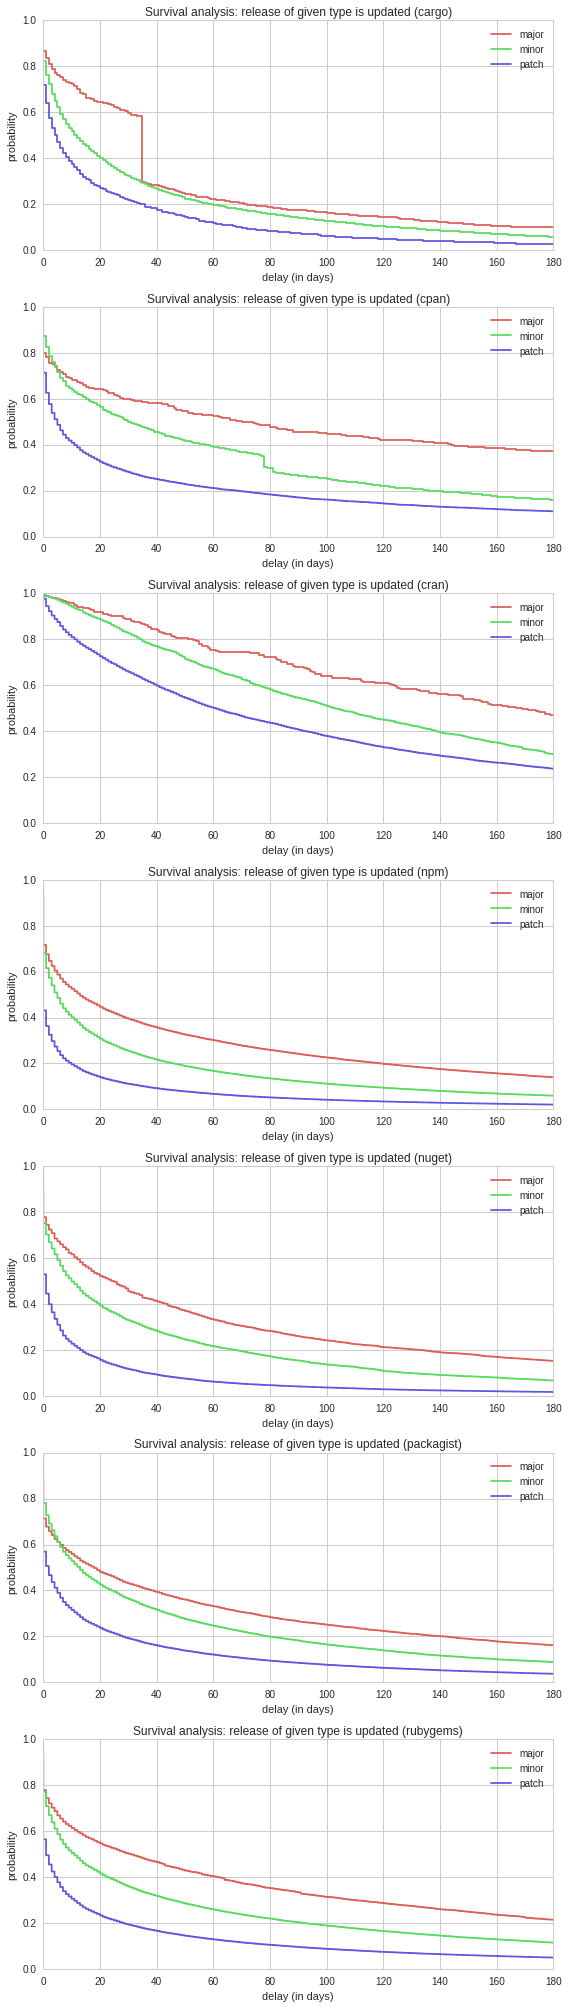

In [33]:
# Delay for an update of a given type, regardless of the type of the previous update

import lifelines
from lifelines.statistics import logrank_test

figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))

colors = iter(itertools.cycle(seaborn.color_palette('hls', 3)))

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
                    
    kmp_df = collections.OrderedDict()
    for update_kind in ['major', 'minor', 'patch']:
        color = next(colors)
        
        kmp_df[update_kind] = (
            data['semver']
            .query('release_type == "{}"'.format(update_kind))
            .assign(duration=lambda d: d['release_delay'].dt.days)
        )

        kmp.fit(kmp_df[update_kind]['duration'], label=update_kind)
        kmp.plot(ax=ax, color=color, ci_show=False)

    tests[ecosystem] = [
        ('major vs minor', logrank_test(kmp_df['major']['duration'], kmp_df['minor']['duration'], alpha=0.99)),
        ('minor vs patch', logrank_test(kmp_df['minor']['duration'], kmp_df['patch']['duration'], alpha=0.99)),
    ]
        
    ax.set(
        xlabel='delay (in days)',
        ylabel='probability', 
        title='Survival analysis: release of given type is updated ({})'.format(ecosystem),
        xlim=(0, 180),
        ylim=(0, 1)
    )    
    
matplotlib.pyplot.tight_layout()    

savefig(figure, 'act_semver_survival_type_is_updated')

In [34]:
for ecosystem, results in tests.items():
    print(ecosystem)
    for label, test in results: 
        print('{}: {}, significant: {}'.format(label, test.test_result, test.is_significant))

cargo
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
cpan
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
cran
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
npm
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
nuget
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
packagist
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
rubygems
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True


In [35]:
# Delay for an update of a given type, wrt. to a previous update of the same type

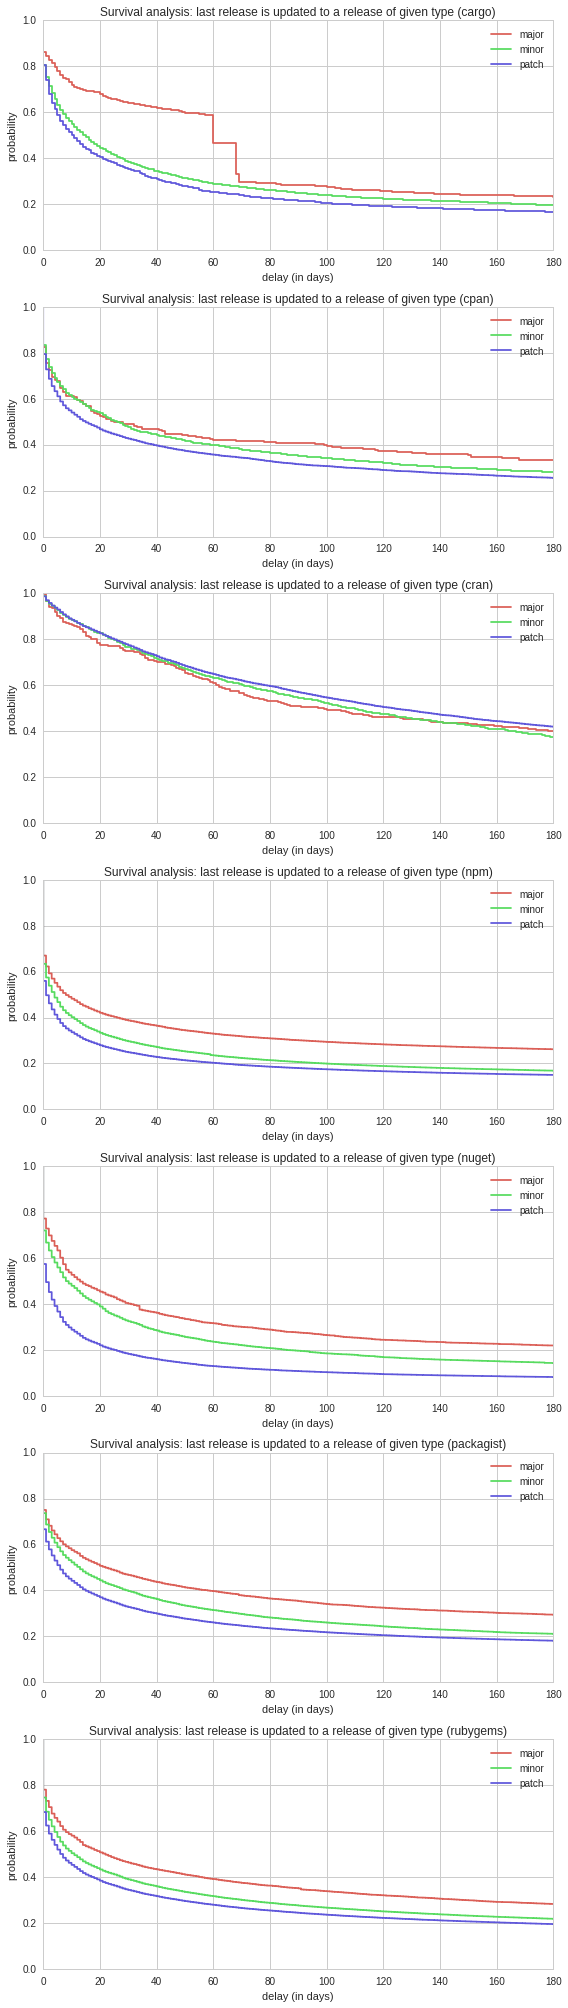

In [36]:
# Delay for an update (no matter its type) wrt. to a previous update of given type

import lifelines
from lifelines.statistics import logrank_test

figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))

colors = iter(itertools.cycle(seaborn.color_palette('hls', 3)))

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
                    
    kmp_df = collections.OrderedDict()
    for update_kind in ['major', 'minor', 'patch']:
        color = next(colors)
        
        kmp_df[update_kind] = (
            data['semver']
            .query('release_type == "{}"'.format(update_kind))
            .assign(duration=lambda d: d['next_release_delay'].dt.days)
        )

        kmp.fit(kmp_df[update_kind]['duration'], label=update_kind)
        kmp.plot(ax=ax, color=color, ci_show=False)

    tests[ecosystem] = [
        ('major vs minor', logrank_test(kmp_df['major']['duration'], kmp_df['minor']['duration'], alpha=0.99)),
        ('minor vs patch', logrank_test(kmp_df['minor']['duration'], kmp_df['patch']['duration'], alpha=0.99)),
    ]
    
    ax.set(
        xlabel='delay (in days)',
        ylabel='probability', 
        title='Survival analysis: last release is updated to a release of given type ({})'.format(ecosystem),
        xlim=(0, 180),
        ylim=(0, 1)
    )    
    
matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_survival_updated_to_type')

In [37]:
for ecosystem, results in tests.items():
    print(ecosystem)
    for label, test in results: 
        print('{}: {}, significant: {}'.format(label, test.test_result, test.is_significant))

cargo
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
cpan
major vs minor: Cannot Reject Null, significant: False
minor vs patch: Cannot Reject Null, significant: False
cran
major vs minor: Cannot Reject Null, significant: False
minor vs patch: Reject Null, significant: True
npm
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
nuget
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
packagist
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
rubygems
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True


## Delay before first dependent

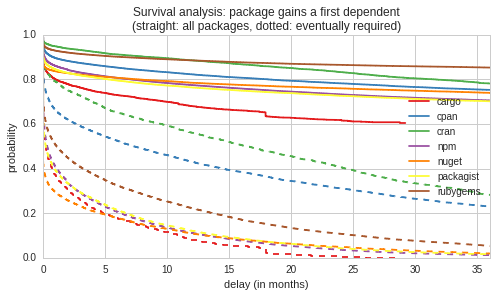

In [38]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    first_dependent = (
        data['packages']
        .merge(data['dependencies'], on=['package', 'version'])
        [['dependency', 'time']]
        .groupby('dependency')
        .min()
        .rename(columns={'time': 'dependent'})
    )

    kmp_df = (
        data['packages']
        .groupby('package')
        [['time']]
        .min()
        .join(first_dependent)
        .assign(observed=lambda d: ~d['dependent'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: (d['dependent'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30)
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
    required = kmp_df['observed'] == True
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'])
    kmp.plot(ax=ax, color=COLORS[ecosystem], style='--', legend=None, ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: package gains a first dependent\n(straight: all packages, dotted: eventually required)',
    xlim=(0, 36),
    ylim=(0, 1)
)    

savefig(figure, 'act_survival_first_dependent')

## Delay between consecutive dependents

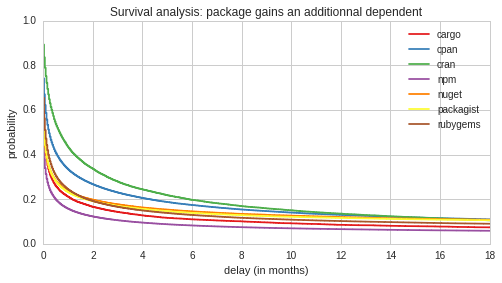

In [39]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    df = (data['dependencies']
     .merge(data['packages'], on=['package', 'version'])
     .groupby(['package', 'dependency'])
     [['time']]
     .min()
     .reset_index()
     [['dependency', 'time']]
     .sort_values(['dependency', 'time'])
     .set_index('dependency')
     .assign(next_dependent=lambda d: d['time'].shift(-1))
     .reset_index()
    )

    index_of_last_dependents = (
        df
        .groupby('dependency', sort=False)
        .tail(1)
        .index
    )

    df.loc[index_of_last_dependents, 'next_dependent'] = pandas.NaT
    
    kmp_df = (
        df
        .assign(observed=lambda d: ~d['next_dependent'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_dependent'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: package gains an additionnal dependent',
    xlim=(0, 18),
    ylim=(0, 1)
)    

savefig(figure, 'act_survival_additionnal_dependent')

## Type of constraints

In [40]:
# TODO

RE_CONSTRAINT = collections.defaultdict(lambda d: r'^(?P<c_op>=|<|>|<=|>=|~|~>|~=|\^)? ?(?P<c_ver>[^=<>~\^,;]+)$')
RE_WILDCARD = collections.defaultdict(lambda d: r'\*|x|X')
RE_SOFT_CONSTRAINT = collections.defaultdict(lambda d: r'http|\^|~|>|<|\*|\.x')
RE_LOWER_CONSTRAINT = collections.defaultdict(lambda d: r'\^|~|>|\.\*|\.x')
RE_UPPER_CONSTRAINT = collections.defaultdict(lambda d: r'\^|~|<|\.\*|\.x')